In [1]:
# Michael Wasserstein
# Plot_Precipitation_Time_Series_For_TECPEC.py
# 10/9/2024

# Script to plot precipitation accumulation from domains 2-4 for the TECPEC simulation at CLN
# As well as the observations

####### Usage #########
# Conda environment - py37
# python /uufs/chpc.utah.edu/common/home/u1371671/WRF/Plotting_Scripts_To_Use_Now/Plot_Precipitation_Time_Series_For_TECPEC.py -r 2 -p 2
# -r represents the run number you want to plot
# -p represents the path of interest


In [2]:
import os, sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u1371671/')
from map_script import *
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors, ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm
import pyart
import metpy.calc as mpcalc
from metpy.units import units

import numpy as np
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair, get_cartopy, ALL_TIMES)
import wrf
import glob
import pandas as pd
import datetime

import urllib.request as req
import os.path
import json
import urllib


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [19]:
time_offset = False

In [4]:
run_list = ['18','19','20','22']
path = 12

In [17]:
if path == 1:
    time_start = '202212120000'
    time_end = '202212150000'
elif (path == 2) or (path == 6) or (path == 12):
    time_start = '201903221200'  # verify this is right
    time_end = '201903230600'
    if int(run) >= 14:
        time_start = '201903221200'  # verify this is right
        time_end = '201903230200'
    if run == '15':
        time_start = '201903220000'  # verify this is right
        time_end = '201903230200'
elif (path == 9) or (path == 8):
    time_start = '202212130000'  # verify this is right
    time_end = '202212140600'
print('Plotting data for run', run,)

Plotting data for run 22


In [7]:
############################
## stuff for synoptic API ##
############################
API_ROOT = "https://api.synopticdata.com/v2/"
API_TOKEN = "0d0f87d395244930af38c1460e0c1a0f"
within = 30 # how many minutes within the time of interest



# paths for saving fig
parent_dir = '/uufs/chpc.utah.edu/common/home/u1371671/WRF/'
Fig_dir = parent_dir + 'Figures_{}/wrf_{}/'.format(path,run_number)

# Make fig dir if it doesn't exist
if os.path.exists(Fig_dir) == False:
    os.mkdir(Fig_dir)

# Dictionary from mesowest
station_dicts = {'CLN' : [40.5763,-111.6383],
                'SLC' : [40.77,-111.95]}
station = 'CLN'

# Stuff for CLN
lat_lon = station_dicts[station] # lat and lon of CLN


In [29]:
list_for_precip = []

for run in run_list:
    
    run_number = '{}'.format(run).zfill(2)
    
    # paths for data
    if path ==1:
        base_path = '/uufs/chpc.utah.edu/common/home/steenburgh-group12/michael/wrf/'
    else:

        base_path = '/uufs/chpc.utah.edu/common/home/steenburgh-group12/michael/wrf{}/'.format(path)
    WRF_path = base_path + 'wrf_runs/wrf_{}/run/'.format(run_number)
    
    ##################################################
    #################WRF STUFF for domain 3########################
    ##################################################
    domain = 3

    # load in all the wrf output data files
    data_files = glob.glob(WRF_path + '*wrfout_d0{}*'.format(domain)) # for the innermost domain
    data_files.sort()

    # Load in all the wrf files
    wrflist = [Dataset(file) for file in data_files]

    # Extract variables of interest
    rain_d03 = wrf.getvar(wrflist, "RAINNC", timeidx=ALL_TIMES, method="cat")
    rainc = wrf.getvar(wrflist, "RAINC", timeidx=ALL_TIMES, method="cat")

    # Get x_y for the location of interest
    x_y = wrf.ll_to_xy(wrflist, lat_lon[0], lat_lon[1]) # some interpolations for the xy of the data

    # Compute total modeled preciptiation
    CLN_modeled_precip_d03 = rain_d03[:,x_y[1], x_y[0]].values + rainc[:,x_y[1], x_y[0]].values #+ rain[:,x_y[1], x_y[0]].values + graupel[:,x_y[1], x_y[0]].values + hail[:,x_y[1], x_y[0]].values

    list_for_precip.append(CLN_modeled_precip_d03)
    



In [30]:
# Get the init times
init_time = wrflist[0].SIMULATION_START_DATE
init_time = datetime.datetime.strptime(init_time, '%Y-%m-%d_%H:%M:%S')
init_time_str = datetime.datetime.strftime(init_time,  '%Y-%m-%d %H:%M:%SZ')

In [31]:
##################################################
#################API STUFF########################
##################################################

# let's get some latest data
api_request_url = os.path.join(API_ROOT, "stations/timeseries")
# the built-in library requires us to specify the URL parameters directly
api_request_url += "?stid=KSLC,CLN&start={}&end={}&token={}".format(time_start, time_end, API_TOKEN) # Extract API data for CLN and KSLC


response = req.urlopen(api_request_url)
api_text_data = response.read() # read the api request

use_data = json.loads(api_text_data) # Now you can work with use_data because it is a dictionary of the data the API returned.

# check the units of the data you're working with
print('Precip units: ', use_data['UNITS']['precip_accum_one_hour'])

######### PRepare CLN Dataset ##########
# Add variables to dataset
df_precip_CLN = pd.DataFrame({'Time' : use_data['STATION'][1]['OBSERVATIONS']['date_time'], 
              'Precip_accum_one_hr' : use_data['STATION'][1]['OBSERVATIONS']['precip_accum_one_hour_set_1'], })

# THe very first data point in this array takes the precip accumulated from the hour *before*. But this is wrong since you should start at zero. Fix that
df_precip_CLN['Precip_accum_one_hr'][0] = 0 

# Extracat the observed precip amounts
CLN_observed_precip_ = df_precip_CLN['Precip_accum_one_hr'].values

# Find the observed precip accumulation
CLN_observed_precip_accum = np.cumsum(CLN_observed_precip_) 

# Extract the times for both the CLN data and for the WRF data
times_precip_CLN = pd.to_datetime(df_precip_CLN.Time.values[::])
times_WRF = pd.to_datetime(rain_d03.Time.values)

print('Now Plotting')

# DO the time offset if you wawnt it
if time_offset:
    times_WRF = times_WRF + datetime.timedelta(hours = time_offset_hours, minutes = time_offset_minutes)  
    save_path = Fig_dir + 'CLN_Accum_Time_Series_time_offset_{}h_{}min.png'.format(time_offset_hours, time_offset_minutes)
else:
    save_path = Fig_dir + 'CLN_Accum_Time_Series.png'

Precip units:  Millimeters
Now Plotting


/scratch/local/u1371671/2534873/ipykernel_868436/2307827436.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precip_CLN['Precip_accum_one_hr'][0] = 0


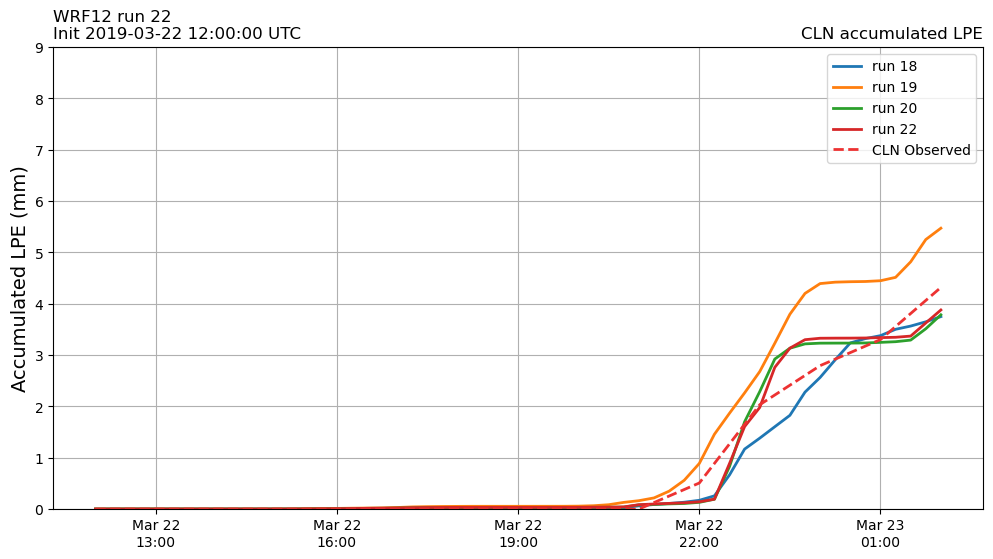

In [32]:
c_CLN = '#ed3232'

# Hour interval for x-axis in plot (the time differences)
hour_interval = 3

#################### Plotting ########################
fig, ax = plt.subplots(1,1,figsize = (12,6),facecolor = 'white', edgecolor = 'k')

for i, precip in enumerate(list_for_precip):
    ax.plot(times_WRF[::], precip[::], linewidth = 2, linestyle = '-', label = f'run {run_list[i]}')
# Plot observations
ax.plot(times_precip_CLN, CLN_observed_precip_accum, color = c_CLN, linewidth = 2, linestyle = '--', label = 'CLN Observed')

# Y label
ax.set_ylabel('Accumulated LPE (mm)', fontsize = 14)

# FOr x ticks
ax.xaxis.set_major_locator(mdates.HourLocator(interval=hour_interval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%H:%M'))

ax.set_ylim(0,round(CLN_observed_precip_accum.max()+5))
#ax.set_xlim(start_time, end_time + datetime.timedelta(minutes = 45))

# Add titles
ax.set_title('WRF{} run {}\nInit {} UTC'.format(path,run_number, init_time), loc = 'left')
ax.set_title('CLN accumulated LPE', loc = 'right')

# Add a legend and a grid
plt.legend()
ax.grid()

# Save figure, show and close
#plt.savefig(save_path, dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()